In [8]:
import matplotlib.pyplot as plt
import numpy as np

import meep as mp

resolution = 50  # pixels/μm

cell_size = mp.Vector3(14, 14)

pml_layers = [mp.PML(thickness=2)]

# rotation angle (in degrees) of waveguide, counter clockwise (CCW) around z-axis
rot_angle = np.radians(20)

w = 1.0  # width of waveguide

geometry = [
    mp.Block(
        center=mp.Vector3(),
        size=mp.Vector3(mp.inf, w, mp.inf),
        e1=mp.Vector3(x=1).rotate(mp.Vector3(z=1), rot_angle),
        e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), rot_angle),
        material=mp.Medium(epsilon=12),
    )
]

fsrc = 0.15  # frequency of eigenmode or constant-amplitude source
bnum = 1  # band number of eigenmode

kpoint = mp.Vector3(x=1).rotate(mp.Vector3(z=1), rot_angle)

In [9]:
compute_flux = False  # compute flux (True) or plot the field profile (False)
eig_src = True  # eigenmode (True) or constant-amplitude (False) source

In [10]:
if eig_src:
    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fsrc, fwidth=0.2 * fsrc)
            if compute_flux
            else mp.ContinuousSource(fsrc),
            center=mp.Vector3(),
            size=mp.Vector3(y=3 * w),
            direction=mp.NO_DIRECTION,
            eig_kpoint=kpoint,
            eig_band=bnum,
            eig_parity=mp.EVEN_Y + mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
            eig_match_freq=True,
        )
    ]
else:
    sources = [
        mp.Source(
            src=mp.GaussianSource(fsrc, fwidth=0.2 * fsrc)
            if compute_flux
            else mp.ContinuousSource(fsrc),
            center=mp.Vector3(),
            size=mp.Vector3(y=3 * w),
            component=mp.Ez,
        )
    ]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources,
    geometry=geometry,
    symmetries=[mp.Mirror(mp.Y)] if rot_angle == 0 else [],
)

     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (0.939693,0.34202,0), (-0.34202,0.939693,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


<AxesSubplot:xlabel='X', ylabel='Y'>

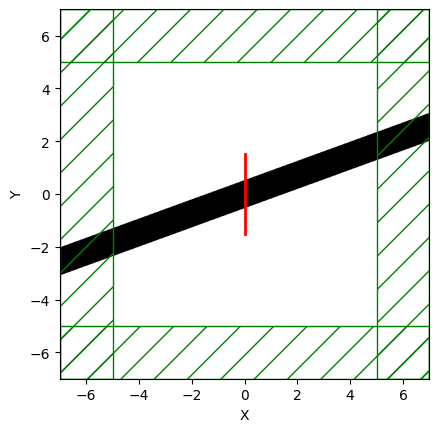

In [11]:
sim.plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00626707 s
Working in 2D dimensions.
Computational cell is 14 x 14 x 0 with resolution 50
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (0.939693,0.34202,0), (-0.34202,0.939693,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.3167 s
-----------
MPB solved for frequency_1(1.06418,0.34202,0) = 0.308936 after 14 iters
MPB solved for frequency_1(0.45724,0.146954,0) = 0.150721 after 7 iters
MPB solved for frequency_1(0.454509,0.146077,0) = 0.15 after 5 iters
MPB solved for frequency_1(0.45451,0.146077,0) = 0.15 after 2 iters
Meep progress: 10.34/100.0 = 10.3% done in 4.0s, 34.7s to go
on time step 1034 (time=10.34), 0.00387221 s/step
Meep progress: 20.97/100.0 = 21.0% done in 8.0s, 30.2s to go
on time step 2098 (time=20.98), 0.00376255 s/step
Meep progress: 31.490000000000002/100.0 = 31.5% done in 12.0s, 26.1s to go
on time step 3151 (time=31.5

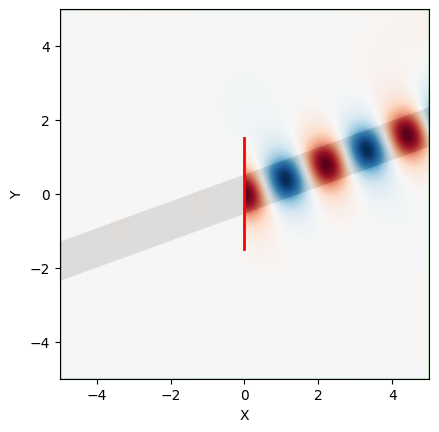

In [12]:
if compute_flux:
    tran = sim.add_flux(
        fsrc, 0, 1, mp.FluxRegion(center=mp.Vector3(x=5), size=mp.Vector3(y=14))
    )
    sim.run(until_after_sources=50)
    res = sim.get_eigenmode_coefficients(
        tran,
        [1],
        eig_parity=mp.EVEN_Y + mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
        direction=mp.NO_DIRECTION,
        kpoint_func=lambda f, n: kpoint,
    )
    print(
        "flux:, {:.6f}, {:.6f}".format(
            mp.get_fluxes(tran)[0], abs(res.alpha[0, 0, 0]) ** 2
        )
    )
else:
    sim.run(until=100)
    sim.plot2D(
        output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(10, 10)),
        fields=mp.Ez,
        field_parameters={"alpha": 0.9},
    )
    plt.show()